# 04. EDS biasing using HTF

Here the collective variable (CV) being biased is the average distance to center of mass.

In [1]:
import hoomd
import hoomd.md
import hoomd.dump
import hoomd.group
import hoomd.htf as htf
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

## Build the computational graph

We first create a CV, the distance from the center of mass for each atom. Then we use EDS to bias the CV to match our target value. Note we add the forces ourselves to the compute graph and they depend on the atom positions, not the distance between atoms. Hoomd-TF requires you to be extra sure you want position dependent forces, because often you can accidentally implicit create position dependent forces. So we add `positions=True` to our `compute_forces` call to say we're sure about computing position dependent forces.

In [2]:
#### Build training graph ####

def make_eds_graph(NN, set_pt):
    # N= Number of atoms in the system 
    # NN=Number of nearest neighbors 
    # set_pt=set point in EDS method
    graph =htf.graph_builder(NN,output_forces=True)
    #calculate center of mass
    com = tf.reduce_mean(graph.positions[:, :2], 0) 
    #calculate distance of each atom from center of mass
    rs = graph.safe_norm(tf.math.subtract(graph.positions[:, :2], com), axis=1) 
    #calculate the average distance from center of mass. This is the collective variable (CV)
    real_cv = tf.reduce_mean(rs) 
    #calculates the running mean of the CV and value
    graph.running_mean(tensor=real_cv,name='cv_run')
    graph.save_tensor(tensor=real_cv,name='cv')
    #calculate the EDS alpha value every 300 steps. 
    eds_alpha = htf.eds_bias(real_cv, set_point=set_pt, period=300,learning_rate=5.0)
    eds_energy = eds_alpha * real_cv #computes EDS energy
    #compute EDS forces
    eds_forces = graph.compute_forces(eds_energy, positions=True)
    graph.save('eds-model',force_tensor=eds_forces,virial=None)


## Running the simulation

This simulation is 64 LJ particles in an NVT ensemble. We save data every 10 steps.

In [3]:
#### Hoomd-Sim code ####

make_eds_graph(32, 4.0)

hoomd.context.initialize("--mode=cpu")
with htf.tfcompute('eds-model', device='CPU:0') as tfcompute:
    #cut off radius: must be less than the box size
    rcut = 6.0 
    #initialize the lattice
    system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sq(a=2.0),n=[8, 8])
    nlist = hoomd.md.nlist.cell(check_period=1)
    #enable lj pair potential
    lj = hoomd.md.pair.lj(rcut, nlist) 
    #set lj coefficients
    lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0) 
    hoomd.md.integrate.mode_standard(dt=0.005)
    # set up NVT simulation
    hoomd.md.integrate.nvt(kT=1.0, tau=0.5,group=hoomd.group.all()) 
    #equilibrate
    hoomd.run(3000)
    #simulation
    tfcompute.attach(nlist, r_cut=rcut,save_period=250)
    hoomd.run(15000)

Note: Backed-up eds-model previous model to eds-model/previous_model_2
HOOMD-blue v2.5.1 DOUBLE HPMC_MIXED SSE SSE2 
Compiled: 03/04/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Started TF Session Manager.
notice(2): Group "all" created containing 64 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 64
notice(2): Neighbors included by diameter          : no
notice(2): N

## Analysis

Now we plot the CV value and its running average to assess if EDS converged

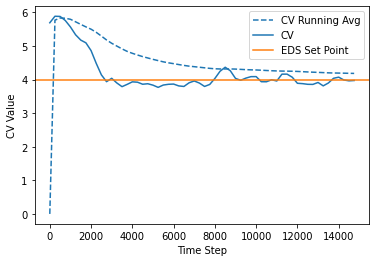

In [6]:
import matplotlib.pyplot as plt
import numpy as np 

cv_value = []
cv_avg = []
# we saved every 10 steps
for i in range(0, 15000, 250):
    variables = htf.load_variables('eds-model', ['cv_run', 'cv'], i)
    # sum energy across particles
    cv_avg.append(variables['cv_run'])
    cv_value.append(variables['cv'])
plt.plot(range(0,15000, 250), cv_avg, label='CV Running Avg', linestyle='--')
plt.plot(range(0,15000, 250), cv_value, label='CV', color='C0')
plt.axhline(4.0, label='EDS Set Point', color='C1')
plt.ylabel('CV Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()